In [2]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2


# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
import datetime
import pickle


# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
# import ffn


# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,dask,numpy,sklearn,statsmodels,scipy,ffn,matplotlib,seaborn

Last updated: 2024-08-22T19:37:44.795179-04:00

Python implementation: CPython
Python version       : 3.8.19
IPython version      : 8.12.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit


pandas           : 2.0.3
pandas_datareader: 0.10.0
dask             : 2023.5.0
numpy            : 1.24.4
sklearn          : 1.3.2
statsmodels      : 0.14.1
scipy            : 1.10.1
ffn              : not installed
matplotlib       : 3.7.3
seaborn          : 0.13.2



/var/folders/j0/8v9qcjfx15g5ftmsy5n0qrq80000gn/T/ipykernel_29220/178535154.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [3]:
import os

# Run the setup script
%run ../../config/setup_project.py

# Call the function to set up the project path
setup_project_path()

# Now you can import your modules
from utils import helper as h_
import ch_02.code_ch_02 as f_ch2

Project root added to sys.path: /Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/src
Current sys.path: ['/Users/paulkelendji/miniconda3/envs/financial_math/lib/python38.zip', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/lib-dynload', '', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages/setuptools/_vendor', '/Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/src']


In [4]:
df = pd.read_parquet("../../data/IVE_kibot.parq")
df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2024-07-26 15:59:46,189.43,189.44,189.46,100,100,18943.00
2024-07-26 15:59:50,189.43,189.41,189.45,150,150,28414.50
2024-07-26 15:59:50,189.42,189.41,189.45,107,107,20267.94


## Code Snippets
Below I reproduce all the relevant code snippets found in the book that are necessary to work through the excercises found at the end of chapter 3.


### Symmetric CUSUM Filter [2.4]


In [5]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)


### Daily Volatility Estimator [3.1]


In [6]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0


### Triple-Barrier Labeling Method [3.2]


In [7]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out


### Gettting Time of First Touch (getEvents) [3.3], [3.6]


In [8]:
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events


### Adding Vertical Barrier [3.4]


In [9]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1


### Labeling for side and size [3.5]


In [10]:

def getBinsOld(events,close):
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # where out index and t1 (vertical barrier) intersect label 0
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


### Expanding getBins to Incorporate Meta-Labeling [3.7]


In [11]:
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


### Dropping Unnecessary Labels [3.8]


In [12]:
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events


### Linear Partitions [20.4.1]


In [13]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts


In [14]:
def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts


### multiprocessing snippet [20.7]


In [15]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0


### single-thread execution for debugging [20.8]


In [16]:
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


### Example of async call to multiprocessing lib [20.9]


In [17]:
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out


### Unwrapping the Callback [20.10]


In [18]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out


### Pickle Unpickling Objects [20.11]


In [19]:
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method, (func_name,obj,cls)
#________________________________
def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)
#________________________________
import copyreg,types, multiprocessing as mp
copyreg.pickle(types.MethodType,_pickle_method,_unpickle_method)

---

# Exercises

In [20]:
# load ../data/variables_ch2.pkl
%run ../ch_02/code_ch_02.py

path = '../../data/variables_ch2.pkl'
import pickle
with open(path, 'rb') as f:
    bars = pickle.load(f)
    bar_time = pickle.load(f)

In [21]:
bars['Dollar'].df_OLHC

,time_open,open,low,high,close,time_close,vwap,volume,cusum
0,2009-09-28 09:30:00,50.7900,50.710,51.9600,51.730,2009-09-29 13:23:42,51.430024,701459,0
1,2009-09-29 13:26:31,51.7275,50.070,51.7600,50.270,2009-10-01 13:44:06,50.908633,709392,0
2,2009-10-01 13:45:10,50.2376,49.190,50.3166,49.761,2009-10-02 14:37:25,49.836850,724111,1
3,2009-10-02 14:38:03,49.7635,49.440,51.4700,51.090,2009-10-07 11:39:00,50.606475,713127,1
4,2009-10-07 11:40:15,51.0880,50.980,52.2252,51.990,2009-10-12 14:24:38,51.675670,698754,0
...,...,...,...,...,...,...,...,...,...
4227,2024-07-24 15:51:05,186.6706,186.460,188.5800,188.400,2024-07-25 11:50:36,187.387274,186271,0
4228,2024-07-25 11:50:40,188.4000,187.685,189.1286,187.685,2024-07-25 14:46:14,188.380972,194394,0
4229,2024-07-25 14:46:35,187.6150,186.980,189.2300,189.020,2024-07-26 10:11:15,187.749127,195797,0
4230,2024-07-26 10:12:45,189.0497,188.665,190.0100,189.460,2024-07-26 15:59:52,189.348801,183912,0


In [22]:
# df as bars['Dollar'].df_OLHC without 'cusum' column
df = bars['Dollar'].df_OLHC.drop(columns=['cusum'])
df

,time_open,open,low,high,close,time_close,vwap,volume
0,2009-09-28 09:30:00,50.7900,50.710,51.9600,51.730,2009-09-29 13:23:42,51.430024,701459
1,2009-09-29 13:26:31,51.7275,50.070,51.7600,50.270,2009-10-01 13:44:06,50.908633,709392
2,2009-10-01 13:45:10,50.2376,49.190,50.3166,49.761,2009-10-02 14:37:25,49.836850,724111
3,2009-10-02 14:38:03,49.7635,49.440,51.4700,51.090,2009-10-07 11:39:00,50.606475,713127
4,2009-10-07 11:40:15,51.0880,50.980,52.2252,51.990,2009-10-12 14:24:38,51.675670,698754
...,...,...,...,...,...,...,...,...
4227,2024-07-24 15:51:05,186.6706,186.460,188.5800,188.400,2024-07-25 11:50:36,187.387274,186271
4228,2024-07-25 11:50:40,188.4000,187.685,189.1286,187.685,2024-07-25 14:46:14,188.380972,194394
4229,2024-07-25 14:46:35,187.6150,186.980,189.2300,189.020,2024-07-26 10:11:15,187.749127,195797
4230,2024-07-26 10:12:45,189.0497,188.665,190.0100,189.460,2024-07-26 15:59:52,189.348801,183912


In [23]:
# For the purpose of this example, remove rows where time_close is duplicated
# (keep the first row)
# Remove rows where time_close is duplicated, keeping the first occurrence
df = df.drop_duplicates(subset='time_close', keep='first')
# set index as 'time_close'
df = df.set_index('time_close')
df

,time_open,open,low,high,close,vwap,volume
time_close,,,,,,,
2009-09-29 13:23:42,2009-09-28 09:30:00,50.7900,50.710,51.9600,51.730,51.430024,701459
2009-10-01 13:44:06,2009-09-29 13:26:31,51.7275,50.070,51.7600,50.270,50.908633,709392
2009-10-02 14:37:25,2009-10-01 13:45:10,50.2376,49.190,50.3166,49.761,49.836850,724111
2009-10-07 11:39:00,2009-10-02 14:38:03,49.7635,49.440,51.4700,51.090,50.606475,713127
2009-10-12 14:24:38,2009-10-07 11:40:15,51.0880,50.980,52.2252,51.990,51.675670,698754
...,...,...,...,...,...,...,...
2024-07-25 11:50:36,2024-07-24 15:51:05,186.6706,186.460,188.5800,188.400,187.387274,186271
2024-07-25 14:46:14,2024-07-25 11:50:40,188.4000,187.685,189.1286,187.685,188.380972,194394
2024-07-26 10:11:15,2024-07-25 14:46:35,187.6150,186.980,189.2300,189.020,187.749127,195797


### 3.1 Form dollar bars for E-mini S&P 500 futures:

**(a)** Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).


In [24]:
# SNIPPET 2.4 THE SYMMETRIC CUSUM FILTER
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)


# SNIPPET 3.1 DAILY VOLATILITY ESTIMATES
def getDailyVol(close, span0=100):
    # daily vol, reindexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=span0).std()
    return df0


In [25]:
close = df['close']
getDailyVol(close, span0=100)

time_close
2009-10-01 13:44:06         NaN
2009-10-02 14:37:25    0.012797
2009-10-07 11:39:00    0.028053
2009-10-12 14:24:38    0.025164
2009-10-15 12:03:22    0.022573
                         ...   
2024-07-25 11:50:36    0.007615
2024-07-25 14:46:14    0.007548
2024-07-26 10:11:15    0.007644
2024-07-26 15:59:52    0.007657
2024-07-26 16:00:00    0.007658
Name: close, Length: 4230, dtype: float64

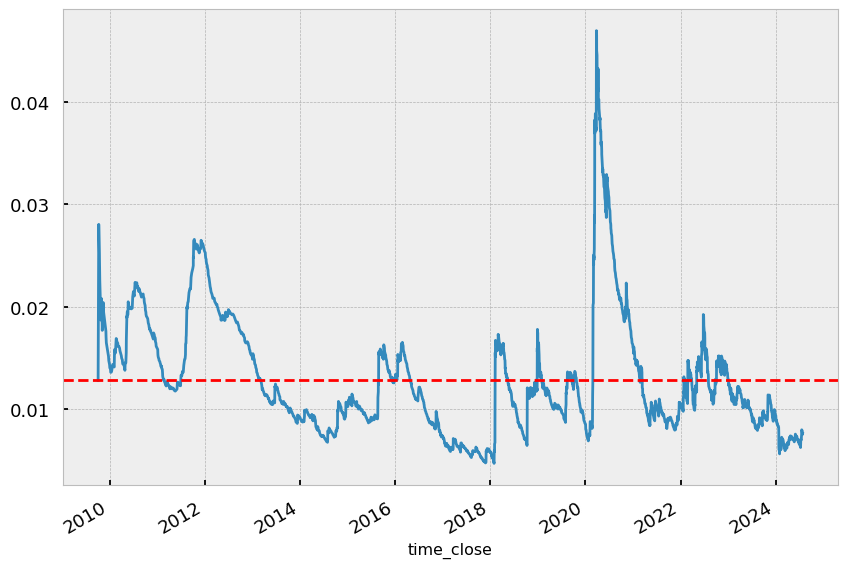

In [26]:
dailyVol = getDailyVol(close, span0=100).dropna()
f,ax=plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(),ls='--',color='r')

In [27]:
# Adapt getTEvents(gRaw, h) so h is a Series of thresholds

# SNIPPET 2.4 THE SYMMETRIC CUSUM FILTER ADDAPTED FOR 3.1
def getTEvents(gRaw, h):
    # inner join to have only the common dates
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff().dropna()
    common_dates = diff.index.intersection(h.index)
    diff = diff.loc[common_dates]
    h = h.loc[common_dates]
    for i in diff.index:
        try:
            sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
            if sNeg < -h.loc[i]:
                sNeg = 0; tEvents.append(i)
            elif sPos > h.loc[i]:
                sPos = 0; tEvents.append(i)
    # return pd.DatetimeIndex(tEvents)
        except Exception as e:
            print(e)
    return tEvents


yt = df['close'].pct_change().dropna()
dailyVol = getDailyVol(close, span0=100).dropna()
tEvents = getTEvents(yt, dailyVol)
print(f"Sampled {len(tEvents)} bars out of {len(df)}")

Sampled 1519 bars out of 4231


In [28]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)



In [29]:
tEvents

[Timestamp('2009-10-02 14:37:25'),
 Timestamp('2009-10-07 11:39:00'),
 Timestamp('2009-10-20 11:12:37'),
 Timestamp('2009-10-27 11:06:15'),
 Timestamp('2009-11-02 10:30:21'),
 Timestamp('2009-11-04 15:15:40'),
 Timestamp('2009-11-13 12:12:50'),
 Timestamp('2009-12-10 10:46:01'),
 Timestamp('2010-01-05 10:51:58'),
 Timestamp('2010-01-11 15:24:27'),
 Timestamp('2010-01-15 12:55:11'),
 Timestamp('2010-02-03 09:30:33'),
 Timestamp('2010-02-05 15:14:59'),
 Timestamp('2010-02-12 09:36:46'),
 Timestamp('2010-02-18 14:22:11'),
 Timestamp('2010-02-24 11:09:37'),
 Timestamp('2010-03-10 12:13:59'),
 Timestamp('2010-03-29 14:30:31'),
 Timestamp('2010-04-15 15:40:45'),
 Timestamp('2010-04-20 15:16:58'),
 Timestamp('2010-04-28 10:37:14'),
 Timestamp('2010-05-03 13:31:41'),
 Timestamp('2010-05-05 10:14:37'),
 Timestamp('2010-05-10 09:31:12'),
 Timestamp('2010-05-11 10:02:32'),
 Timestamp('2010-05-11 13:20:35'),
 Timestamp('2010-05-14 12:07:42'),
 Timestamp('2010-05-17 15:46:08'),
 Timestamp('2010-05-

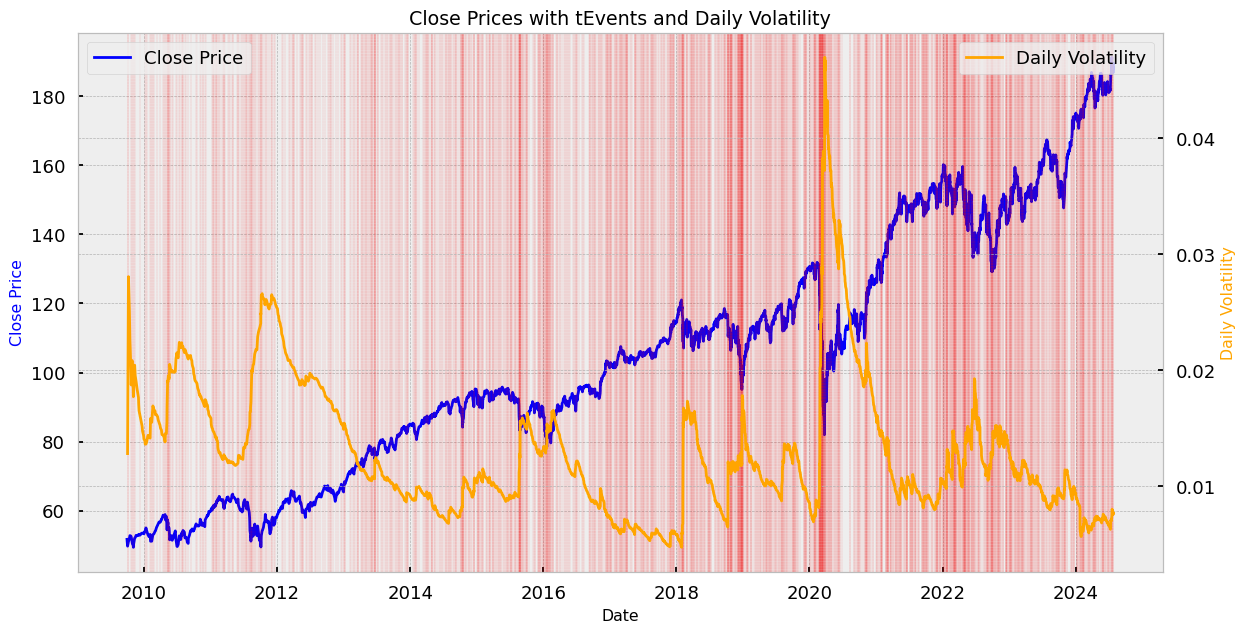

In [30]:
# Plotting the close prices
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(df.index, df['close'], label='Close Price', color='blue')

# Plotting the tEvents as vertical lines
for event in tEvents:
    ax1.axvline(x=event, color='red', linestyle='--', lw=0.1)

# Create a secondary y-axis for the daily volatility
ax2 = ax1.twinx()
ax2.plot(dailyVol.index, dailyVol, label='Daily Volatility', color='orange')

# Adding labels and titles
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax2.set_ylabel('Daily Volatility', color='orange')
ax1.set_title('Close Prices with tEvents and Daily Volatility')

# Showing legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


### b) Use Snippet 3.4 on a pandas series t1, where numDays = 1

In [31]:
# SNIPPET 3.4 ADDING A VERTICAL BARRIER

def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

t1 = addVerticalBarrier(tEvents, close, numDays=1)
t1

TypeError: can only concatenate list (not "Timedelta") to list

In [32]:
"""The error occurs because `tEvents` is a list, and 
`pd.Timedelta(days=numDays)` cannot be directly added to a list. You need to 
convert `tEvents` to a pandas `DatetimeIndex` or a `Series` before performing 
the addition.

Here's how you can modify the `addVerticalBarrier` function to fix this issue:
"""

def addVerticalBarrier(tEvents, close, numDays=1):
    # Convert tEvents to a DatetimeIndex
    tEvents = pd.DatetimeIndex(tEvents)
    
    # Add the time delta to tEvents
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    
    # Ensure t1 does not go beyond the available close data
    t1 = t1[t1 < close.shape[0]]
    
    # Create a Series with t1 as the index and tEvents as values
    t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]])
    
    return t1

# Run the function with tEvents and close
t1 = addVerticalBarrier(tEvents, close, numDays=10)
t1


2009-10-02 14:37:25   2009-10-15 12:03:22
2009-10-07 11:39:00   2009-10-20 11:12:37
2009-10-20 11:12:37   2009-11-02 10:30:21
2009-10-27 11:06:15   2009-11-10 10:55:00
2009-11-02 10:30:21   2009-11-13 12:12:50
                              ...        
2024-07-02 14:11:15   2024-07-12 16:00:00
2024-07-10 13:21:10   2024-07-22 14:12:45
2024-07-11 12:01:59   2024-07-22 14:12:45
2024-07-12 16:00:00   2024-07-23 10:51:52
2024-07-16 10:07:09   2024-07-26 10:11:15
Name: time_close, Length: 1513, dtype: datetime64[ns]

In [34]:
t1[1]

Timestamp('2009-10-20 11:12:37')

## (c) On those sampled features, apply the triple-barrier method, where `ptSl = [1, 1]` and `t1` is the series you created in point 1.b.


In [35]:
# SNIPPET 3.6 EXPANDING getEvents TO INCORPORATE META-LABELING

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def applyPtSlOnT1(close, events, ptSl, molecule):
    # Apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0] > 0: 
        pt = ptSl[0] * events_['trgt']
    else: 
        pt = pd.Series(index=events.index)  # NaNs
    if ptSl[1] > 0: 
        sl = -ptSl[1] * events_['trgt']
    else: 
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out

def mpPandasObj(func, pdObj, numThreads=24, mpBatches=1, linMols=True, **kargs):
    import pandas as pd
    
    if linMols:
        parts = linParts(len(pdObj[1]), numThreads * mpBatches)
    else:
        parts = nestedParts(len(pdObj[1]), numThreads * mpBatches)

    jobs = []
    for i in range(1, len(parts)):
        job = {pdObj[0]: pdObj[1][parts[i-1]:parts[i]], 'func': func}
        job.update(kargs)
        jobs.append(job)
        
    if numThreads == 1:
        out = processJobs_(jobs)
    else:
        out = processJobs(jobs, numThreads=numThreads)
        
    if isinstance(out[0], pd.DataFrame):
        df0 = pd.DataFrame()
    elif isinstance(out[0], pd.Series):
        df0 = pd.Series()
    else:
        return out

    for i in out:
        df0 = pd.concat([df0, i])
        
    df0 = df0.sort_index()
    return df0



In [170]:
# create target series
ptsl = [1,1]
target=dailyVol
# select minRet
minRet = 0.01

import multiprocessing
num_cores = multiprocessing.cpu_count()-1

events = getEvents(close,tEvents,ptsl,target,minRet,numThreads = 1 ,t1=t1)
events


,t1,trgt
2009-10-02 14:37:25,2009-10-07 11:39:00,0.012797
2009-10-07 11:39:00,2009-10-15 12:03:22,0.028053
2009-10-20 11:12:37,2009-10-27 11:06:15,0.020279
2009-10-27 11:06:15,2009-11-03 11:21:01,0.020823
2009-11-02 10:30:21,2009-11-10 10:55:00,0.018378
...,...,...
2023-11-02 13:19:47,2023-11-03 12:07:30,0.010664
2023-11-03 12:07:30,2023-11-14 10:00:23,0.011264
2023-11-03 15:23:46,2023-11-14 10:00:23,0.011404
2023-11-14 10:00:23,2023-11-20 13:08:22,0.011173


### (d) Apply `getBins` to generate labels

In [171]:
# **SNIPPET 3.5** **LABELING FOR SIDE AND SIZE**

def getBins(events, close):
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    out['bin'] = np.sign(out['ret'])
    return out

In [172]:
labels = getBins(events, close)
labels['bin'].value_counts()

# delete row where bin is 0
labels = labels[labels['bin'] != 0]
labels['bin'].value_counts()

bin
 1.0    557
-1.0    410
Name: count, dtype: int64

In [173]:
labels

,ret,bin
2009-10-02 14:37:25,0.026708,1.0
2009-10-07 11:39:00,0.033647,1.0
2009-10-20 11:12:37,-0.034529,-1.0
2009-10-27 11:06:15,-0.028689,-1.0
2009-11-02 10:30:21,0.038788,1.0
...,...,...
2023-11-02 13:19:47,0.016538,1.0
2023-11-03 12:07:30,0.023062,1.0
2023-11-03 15:23:46,0.021314,1.0
2023-11-14 10:00:23,0.015028,1.0


# 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [174]:
# **SNIPPET 3.8** **DROPPING UNDER-POPULATED LABELS**


def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0 = events['bin'].value_counts(normalize=True)
        if df0.min() > minPct or df0.shape[0] < 3: break
        print('dropped label', df0.argmin(), df0.min())
        events = events[events['bin'] != df0.argmin()]
    return events

clean_labels = dropLabels(labels)
clean_labels['bin'].value_counts()


bin
 1.0    557
-1.0    410
Name: count, dtype: int64

# 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.

In [175]:
def getBinsNew(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    
    if 'side' not in events_:
        # only applies when not meta-labeling
        # to update bin to 0 when vertical barrier is touched, we need the original
        # vertical barrier series since the events['t1'] is the time of first 
        # touch of any barrier and not the vertical barrier specifically. 
        # The index of the intersection of the vertical barrier values and the 
        # events['t1'] values indicate which bin labels needs to be turned to 0
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.
    
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

labelsNew = getBinsNew(events, close, t1=t1)
labelsNew['bin'].value_counts()


bin
 0.0    405
 1.0    316
-1.0    246
Name: count, dtype: int64

In [176]:
# clean_labels = dropLabels(labelsNew)
# clean_labels['bin'].value_counts()

**3.4** Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

- **(a)** Derive meta-labels for `ptSl = [1, 2]` and `t1` where `numDays = 1`. Use as `trgt` the daily standard deviation as computed by Snippet 3.1.
  
- **(b)** Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, `{0, 1}`, since the underlying model (the crossing moving average) has decided the side, `{-1, 1}`.


## 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

In [177]:
close

time_close
2009-09-29 13:23:42     51.730
2009-10-01 13:44:06     50.270
2009-10-02 14:37:25     49.761
2009-10-07 11:39:00     51.090
2009-10-12 14:24:38     51.990
                        ...   
2024-07-25 11:50:36    188.400
2024-07-25 14:46:14    187.685
2024-07-26 10:11:15    189.020
2024-07-26 15:59:52    189.460
2024-07-26 16:00:00    189.390
Name: close, Length: 4231, dtype: float64

In [178]:
labels

,ret,bin
2009-10-02 14:37:25,0.026708,1.0
2009-10-07 11:39:00,0.033647,1.0
2009-10-20 11:12:37,-0.034529,-1.0
2009-10-27 11:06:15,-0.028689,-1.0
2009-11-02 10:30:21,0.038788,1.0
...,...,...
2023-11-02 13:19:47,0.016538,1.0
2023-11-03 12:07:30,0.023062,1.0
2023-11-03 15:23:46,0.021314,1.0
2023-11-14 10:00:23,0.015028,1.0


Here are some ideas for trend-following strategies based on popular technical analysis techniques:

### 1. **Moving Average Crossover**
   - **Concept:** A basic trend-following strategy where you buy when a shorter-term moving average crosses above a longer-term moving average (bullish crossover) and sell when the shorter-term moving average crosses below the longer-term moving average (bearish crossover).
   - **Variables:**
     - Short-term Moving Average: 50-period
     - Long-term Moving Average: 200-period
   - **Signal:**
     - Buy when the 50-day MA crosses above the 200-day MA.
     - Sell when the 50-day MA crosses below the 200-day MA.

### 2. **Relative Strength Index (RSI) Strategy**
   - **Concept:** RSI is a momentum oscillator that measures the speed and change of price movements. This strategy buys when RSI is below 30 (oversold) and sells when RSI is above 70 (overbought).
   - **Variables:**
     - RSI Period: 14
     - Overbought Level: 70
     - Oversold Level: 30
   - **Signal:**
     - Buy when RSI crosses below 30.
     - Sell when RSI crosses above 70.

### 3. **Bollinger Bands**
   - **Concept:** Bollinger Bands are a volatility indicator that consists of a moving average and two standard deviations plotted above and below it. The strategy buys when the price touches the lower band and sells when it touches the upper band.
   - **Variables:**
     - Moving Average Period: 20
     - Band Width: 2 standard deviations
   - **Signal:**
     - Buy when the price touches the lower Bollinger Band.
     - Sell when the price touches the upper Bollinger Band.

### 4. **MACD (Moving Average Convergence Divergence)**
   - **Concept:** The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The strategy buys when the MACD line crosses above the signal line and sells when it crosses below.
   - **Variables:**
     - Fast EMA: 12-period
     - Slow EMA: 26-period
     - Signal Line: 9-period EMA of the MACD line
   - **Signal:**
     - Buy when the MACD line crosses above the signal line.
     - Sell when the MACD line crosses below the signal line.

### 5. **Donchian Channel Breakout**
   - **Concept:** The Donchian Channel is a trend-following indicator formed by taking the highest high and the lowest low of the last ‘n’ periods. The strategy buys when the price breaks above the upper band and sells when it breaks below the lower band.
   - **Variables:**
     - Donchian Period: 20
   - **Signal:**
     - Buy when the price breaks above the upper Donchian Channel.
     - Sell when the price breaks below the lower Donchian Channel.

### 6. **Parabolic SAR**
   - **Concept:** The Parabolic SAR (Stop and Reverse) is a trend-following indicator that places dots below the price during an uptrend and above the price during a downtrend. The strategy buys when the dots move below the price and sells when they move above the price.
   - **Variables:**
     - Step: 0.02
     - Maximum: 0.2
   - **Signal:**
     - Buy when the Parabolic SAR dot is below the price.
     - Sell when the Parabolic SAR dot is above the price.

These strategies can be implemented and tested to see which one aligns best with your data and objectives.

In [179]:
"""
### 1. **Moving Average Crossover**
   - **Concept:** A basic trend-following strategy where you buy when a 
                    shorter-term moving average crosses above a longer-term 
                    moving average (bullish crossover) and sell when the 
                    shorter-term moving average crosses below the longer-term 
                    moving average (bearish crossover).
   - **Variables:**
     - Short-term Moving Average: 50-period
     - Long-term Moving Average: 200-period
   - **Signal:**
     - Buy when the 50-day MA crosses above the 200-day MA.
     - Sell when the 50-day MA crosses below the 200-day MA.
"""
short_window = 5
long_window = 20

strategy = pd.DataFrame(close)
strategy['short_mavg'] = close.ewm(span=short_window, min_periods=1).mean()
strategy['long_mavg'] = close.ewm(span=long_window, min_periods=1).mean()

def compute_MAC_signal(df: pd.DataFrame):
    df_lag = df.shift(1)
    
    # buy signal
    buy = (df['short_mavg'] > df['long_mavg']) & (df_lag['short_mavg'] <= df_lag['long_mavg'])
    buy = buy.astype(int)
    
    # sell signal
    sell = (df['short_mavg'] < df['long_mavg']) & (df_lag['short_mavg'] >= df_lag['long_mavg'])
    sell = -sell.astype(int)
    
    df['diff'] = strategy['short_mavg'] - strategy['long_mavg']
    df['signal'] = buy + sell
    return df

strategy = compute_MAC_signal(strategy)
strategy['signal'].value_counts()


signal
 0    3971
-1     130
 1     130
Name: count, dtype: int64

In [180]:

strategy['signal'].iloc[:long_window]=0
strategy


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,close,short_mavg,long_mavg,diff,signal
time_close,,,,,
2009-09-29 13:23:42,51.730,51.730000,51.730000,0.000000,0
2009-10-01 13:44:06,50.270,50.854000,50.963500,-0.109500,0
2009-10-02 14:37:25,49.761,50.336263,50.521949,-0.185686,0
2009-10-07 11:39:00,51.090,50.649354,50.685937,-0.036583,0
2009-10-12 14:24:38,51.990,51.164009,51.001379,0.162631,0
...,...,...,...,...,...
2024-07-25 11:50:36,188.400,187.602017,186.972521,0.629496,0
2024-07-25 14:46:14,187.685,187.629678,187.040376,0.589302,0
2024-07-26 10:11:15,189.020,188.093118,187.228911,0.864207,0


## **(a)** Derive meta-labels for `ptSl = [1, 2]` and `t1` where `numDays = 1`. Use as `trgt` the daily standard deviation as computed by Snippet 3.1.

In [181]:
events

,t1,trgt
2009-10-02 14:37:25,2009-10-07 11:39:00,0.012797
2009-10-07 11:39:00,2009-10-15 12:03:22,0.028053
2009-10-20 11:12:37,2009-10-27 11:06:15,0.020279
2009-10-27 11:06:15,2009-11-03 11:21:01,0.020823
2009-11-02 10:30:21,2009-11-10 10:55:00,0.018378
...,...,...
2023-11-02 13:19:47,2023-11-03 12:07:30,0.010664
2023-11-03 12:07:30,2023-11-14 10:00:23,0.011264
2023-11-03 15:23:46,2023-11-14 10:00:23,0.011404
2023-11-14 10:00:23,2023-11-20 13:08:22,0.011173


In [182]:
close

time_close
2009-09-29 13:23:42     51.730
2009-10-01 13:44:06     50.270
2009-10-02 14:37:25     49.761
2009-10-07 11:39:00     51.090
2009-10-12 14:24:38     51.990
                        ...   
2024-07-25 11:50:36    188.400
2024-07-25 14:46:14    187.685
2024-07-26 10:11:15    189.020
2024-07-26 15:59:52    189.460
2024-07-26 16:00:00    189.390
Name: close, Length: 4231, dtype: float64

In [183]:
t1

2009-10-02 14:37:25   2009-10-15 12:03:22
2009-10-07 11:39:00   2009-10-20 11:12:37
2009-10-20 11:12:37   2009-11-02 10:30:21
2009-10-27 11:06:15   2009-11-10 10:55:00
2009-11-02 10:30:21   2009-11-13 12:12:50
                              ...        
2024-07-02 14:11:15   2024-07-12 16:00:00
2024-07-10 13:21:10   2024-07-22 14:12:45
2024-07-11 12:01:59   2024-07-22 14:12:45
2024-07-12 16:00:00   2024-07-23 10:51:52
2024-07-16 10:07:09   2024-07-26 10:11:15
Name: time_close, Length: 1513, dtype: datetime64[ns]

In [184]:
strategy

,close,short_mavg,long_mavg,diff,signal
time_close,,,,,
2009-09-29 13:23:42,51.730,51.730000,51.730000,0.000000,0
2009-10-01 13:44:06,50.270,50.854000,50.963500,-0.109500,0
2009-10-02 14:37:25,49.761,50.336263,50.521949,-0.185686,0
2009-10-07 11:39:00,51.090,50.649354,50.685937,-0.036583,0
2009-10-12 14:24:38,51.990,51.164009,51.001379,0.162631,0
...,...,...,...,...,...
2024-07-25 11:50:36,188.400,187.602017,186.972521,0.629496,0
2024-07-25 14:46:14,187.685,187.629678,187.040376,0.589302,0
2024-07-26 10:11:15,189.020,188.093118,187.228911,0.864207,0


In [185]:
# **SNIPPET 3.7** **EXPANDING `getBins` TO INCORPORATE META-LABELING**

def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    - events.index is event's starttime
    - events['t1'] is event's endtime
    - events['trgt'] is event's target
    - events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    
    #2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out



In [186]:
# **SNIPPET 3.6** **EXPANDING `getEvents` TO INCORPORATE META-LABELING**


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    # 1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]  # minRet
    
    # 2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    
    # 3) form events object, apply stop loss on t1
    if side is None:
        side_ = pd.Series(1., index=trgt.index)
        ptSl_ = [ptSl[0], ptSl[0]]
    else:
        side_ = side.loc[trgt.index]
        ptSl_ = [ptSl[0], ptSl[1]]  # Use the list directly
    
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])
    df0 = mpPandasObj(func=applyPtSlOnT1, pdObj=('molecule', events.index), numThreads=numThreads, close=close, events=events, ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan
    if side is None:
        events = events.drop('side', axis=1)
    return events



In [187]:
target

time_close
2009-10-02 14:37:25    0.012797
2009-10-07 11:39:00    0.028053
2009-10-12 14:24:38    0.025164
2009-10-15 12:03:22    0.022573
2009-10-20 11:12:37    0.020279
                         ...   
2024-07-25 11:50:36    0.007615
2024-07-25 14:46:14    0.007548
2024-07-26 10:11:15    0.007644
2024-07-26 15:59:52    0.007657
2024-07-26 16:00:00    0.007658
Name: close, Length: 4229, dtype: float64

In [188]:
strategy

,close,short_mavg,long_mavg,diff,signal
time_close,,,,,
2009-09-29 13:23:42,51.730,51.730000,51.730000,0.000000,0
2009-10-01 13:44:06,50.270,50.854000,50.963500,-0.109500,0
2009-10-02 14:37:25,49.761,50.336263,50.521949,-0.185686,0
2009-10-07 11:39:00,51.090,50.649354,50.685937,-0.036583,0
2009-10-12 14:24:38,51.990,51.164009,51.001379,0.162631,0
...,...,...,...,...,...
2024-07-25 11:50:36,188.400,187.602017,186.972521,0.629496,0
2024-07-25 14:46:14,187.685,187.629678,187.040376,0.589302,0
2024-07-26 10:11:15,189.020,188.093118,187.228911,0.864207,0


In [189]:
# create target series
ptsl = [1,2]
target=dailyVol
# select minRet
minRet = 0.01

import multiprocessing
num_cores = multiprocessing.cpu_count()-1

# Match the index
df_ = pd.merge(target, strategy, how='left', left_index=True, right_index=True, suffixes=('_vol', '_price'))

In [190]:
# Reindex side to match trgt.index
aligned_side = df_['signal']
aligned_side

time_close
2009-10-02 14:37:25    0
2009-10-07 11:39:00    0
2009-10-12 14:24:38    0
2009-10-15 12:03:22    0
2009-10-20 11:12:37    0
                      ..
2024-07-25 11:50:36    0
2024-07-25 14:46:14    0
2024-07-26 10:11:15    0
2024-07-26 15:59:52    0
2024-07-26 16:00:00    0
Name: signal, Length: 4229, dtype: int64

In [191]:
events = getEvents(close,tEvents,ptsl,target,minRet,numThreads = 1 ,t1=t1, side=aligned_side)
events

,t1,trgt,side
2009-10-02 14:37:25,2009-10-15 12:03:22,0.012797,0.0
2009-10-07 11:39:00,2009-10-20 11:12:37,0.028053,0.0
2009-10-20 11:12:37,2009-11-02 10:30:21,0.020279,0.0
2009-10-27 11:06:15,2009-11-10 10:55:00,0.020823,0.0
2009-11-02 10:30:21,2009-11-13 12:12:50,0.018378,0.0
...,...,...,...
2023-11-02 13:19:47,2023-11-03 12:07:30,0.010664,1.0
2023-11-03 12:07:30,2023-11-14 10:00:23,0.011264,0.0
2023-11-03 15:23:46,2023-11-14 10:00:23,0.011404,0.0
2023-11-14 10:00:23,2023-11-24 10:33:05,0.011173,0.0


In [192]:
metaLabels = getBins(events, close)
metaLabels['bin'].value_counts()

bin
0.0    923
1.0     44
Name: count, dtype: int64

In [193]:
metaLabels

,ret,bin
2009-10-02 14:37:25,0.000000,0.0
2009-10-07 11:39:00,0.000000,0.0
2009-10-20 11:12:37,-0.000000,0.0
2009-10-27 11:06:15,0.000000,0.0
2009-11-02 10:30:21,0.000000,0.0
...,...,...
2023-11-02 13:19:47,0.016538,1.0
2023-11-03 12:07:30,0.000000,0.0
2023-11-03 15:23:46,0.000000,0.0
2023-11-14 10:00:23,0.000000,0.0


In [194]:
df_

,close_vol,close_price,short_mavg,long_mavg,diff,signal
time_close,,,,,,
2009-10-02 14:37:25,0.012797,49.761,50.336263,50.521949,-0.185686,0
2009-10-07 11:39:00,0.028053,51.090,50.649354,50.685937,-0.036583,0
2009-10-12 14:24:38,0.025164,51.990,51.164009,51.001379,0.162631,0
2009-10-15 12:03:22,0.022573,52.809,51.765111,51.382704,0.382407,0
2009-10-20 11:12:37,0.020279,52.710,52.099654,51.633663,0.465991,0
...,...,...,...,...,...,...
2024-07-25 11:50:36,0.007615,188.400,187.602017,186.972521,0.629496,0
2024-07-25 14:46:14,0.007548,187.685,187.629678,187.040376,0.589302,0
2024-07-26 10:11:15,0.007644,189.020,188.093118,187.228911,0.864207,0


In [195]:
events

,t1,trgt,side
2009-10-02 14:37:25,2009-10-15 12:03:22,0.012797,0.0
2009-10-07 11:39:00,2009-10-20 11:12:37,0.028053,0.0
2009-10-20 11:12:37,2009-11-02 10:30:21,0.020279,0.0
2009-10-27 11:06:15,2009-11-10 10:55:00,0.020823,0.0
2009-11-02 10:30:21,2009-11-13 12:12:50,0.018378,0.0
...,...,...,...
2023-11-02 13:19:47,2023-11-03 12:07:30,0.010664,1.0
2023-11-03 12:07:30,2023-11-14 10:00:23,0.011264,0.0
2023-11-03 15:23:46,2023-11-14 10:00:23,0.011404,0.0
2023-11-14 10:00:23,2023-11-24 10:33:05,0.011173,0.0


In [207]:
dataset = pd.merge(metaLabels, df_, how='left', left_index=True, right_index=True)
dataset = pd.merge(dataset, events, how='left', left_index=True, right_index=True)
dataset

,ret,bin,close_vol,close_price,short_mavg,long_mavg,diff,signal,t1,trgt,side
2009-10-02 14:37:25,0.000000,0.0,0.012797,49.7610,50.336263,50.521949,-0.185686,0,2009-10-15 12:03:22,0.012797,0.0
2009-10-07 11:39:00,0.000000,0.0,0.028053,51.0900,50.649354,50.685937,-0.036583,0,2009-10-20 11:12:37,0.028053,0.0
2009-10-20 11:12:37,-0.000000,0.0,0.020279,52.7100,52.099654,51.633663,0.465991,0,2009-11-02 10:30:21,0.020279,0.0
2009-10-27 11:06:15,0.000000,0.0,0.020823,50.8900,51.765601,51.632849,0.132752,0,2009-11-10 10:55:00,0.020823,0.0
2009-11-02 10:30:21,0.000000,0.0,0.018378,50.1500,50.906985,51.258207,-0.351222,0,2009-11-13 12:12:50,0.018378,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-02 13:19:47,0.016538,1.0,0.010664,154.8392,152.860641,152.309153,0.551489,1,2023-11-03 12:07:30,0.010664,1.0
2023-11-03 12:07:30,0.000000,0.0,0.011264,157.4000,154.895840,153.043955,1.851886,0,2023-11-14 10:00:23,0.011264,0.0
2023-11-03 15:23:46,0.000000,0.0,0.011404,157.6694,155.820360,153.484473,2.335887,0,2023-11-14 10:00:23,0.011404,0.0
2023-11-14 10:00:23,0.000000,0.0,0.011173,161.0300,158.408997,155.320574,3.088423,0,2023-11-24 10:33:05,0.011173,0.0


In [208]:
dataset.info()
# set bin, signal as int
dataset['bin'] = dataset['bin'].astype(int)
dataset['signal'] = dataset['signal'].astype(int)
dataset['side'] = dataset['side'].astype(int)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 967 entries, 2009-10-02 14:37:25 to 2023-11-14 15:59:59
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ret          967 non-null    float64       
 1   bin          967 non-null    float64       
 2   close_vol    967 non-null    float64       
 3   close_price  967 non-null    float64       
 4   short_mavg   967 non-null    float64       
 5   long_mavg    967 non-null    float64       
 6   diff         967 non-null    float64       
 7   signal       967 non-null    int64         
 8   t1           967 non-null    datetime64[ns]
 9   trgt         967 non-null    float64       
 10  side         967 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 122.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 967 entries, 2009-10-02 14:37:25 to 2023-11-14 15:59:59
Data columns (total 11 columns):
 #   Col

## **(b)** Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, `{0, 1}`, since the underlying model (the crossing moving average) has decided the side, `{-1, 1}`.


In [209]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, accuracy_score, make_scorer, f1_score



In [210]:
dataset
# preprocess close_vol, close_price, short_mavg, long_mavg columns by min-max scaling
# preprocess diff column by standard scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaler_diff = StandardScaler()

dataset['close_vol'] = scaler.fit_transform(dataset['close_vol'].values.reshape(-1, 1))
dataset['close_price'] = scaler.fit_transform(dataset['close_price'].values.reshape(-1, 1))
dataset['short_mavg'] = scaler.fit_transform(dataset['short_mavg'].values.reshape(-1, 1))
dataset['long_mavg'] = scaler.fit_transform(dataset['long_mavg'].values.reshape(-1, 1))
dataset['diff'] = scaler_diff.fit_transform(dataset['diff'].values.reshape(-1, 1))

dataset

,ret,bin,close_vol,close_price,short_mavg,long_mavg,diff,signal,t1,trgt,side
2009-10-02 14:37:25,0.000000,0,0.075537,0.002091,0.000000,0.000000,0.044830,0,2009-10-15 12:03:22,0.012797,0
2009-10-07 11:39:00,0.000000,0,0.488328,0.013966,0.002870,0.001527,0.130126,0,2009-10-20 11:12:37,0.028053,0
2009-10-20 11:12:37,-0.000000,0,0.277976,0.028442,0.016166,0.010353,0.417626,0,2009-11-02 10:30:21,0.020279,0
2009-10-27 11:06:15,0.000000,0,0.292701,0.012179,0.013103,0.010345,0.226995,0,2009-11-10 10:55:00,0.020823,0
2009-11-02 10:30:21,0.000000,0,0.226543,0.005567,0.005232,0.006856,-0.049866,0,2009-11-13 12:12:50,0.018378,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-02 13:19:47,0.016538,1,0.017813,0.941018,0.939874,0.947907,0.466536,1,2023-11-03 12:07:30,0.010664,1
2023-11-03 12:07:30,0.000000,0,0.034042,0.963901,0.958532,0.954750,1.210436,0,2023-11-14 10:00:23,0.011264,0
2023-11-03 15:23:46,0.000000,0,0.037840,0.966308,0.967007,0.958852,1.487312,0,2023-11-14 10:00:23,0.011404,0
2023-11-14 10:00:23,0.000000,0,0.031585,0.996336,0.990738,0.975951,1.917806,0,2023-11-24 10:33:05,0.011173,0


In [211]:
# Assume dataset is already defined and contains your features and target

# Select features and target
X = dataset[['close_vol', 'close_price', 'short_mavg', 'long_mavg', 'diff', 'signal']]
y = dataset['bin']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize scalers
scaler = MinMaxScaler()
scaler_diff = StandardScaler()

# Fit the scalers only on the training data
X_train[['close_vol', 'close_price', 'short_mavg', 'long_mavg']] = scaler.fit_transform(X_train[['close_vol', 'close_price', 'short_mavg', 'long_mavg']])
X_train['diff'] = scaler_diff.fit_transform(X_train['diff'].values.reshape(-1, 1))

# Apply the transformations to the test data
X_test[['close_vol', 'close_price', 'short_mavg', 'long_mavg']] = scaler.transform(X_test[['close_vol', 'close_price', 'short_mavg', 'long_mavg']])
X_test['diff'] = scaler_diff.transform(X_test['diff'].values.reshape(-1, 1))



Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       186
           1       0.70      0.88      0.78         8

    accuracy                           0.98       194
   macro avg       0.85      0.93      0.88       194
weighted avg       0.98      0.98      0.98       194

Accuracy: 0.9794


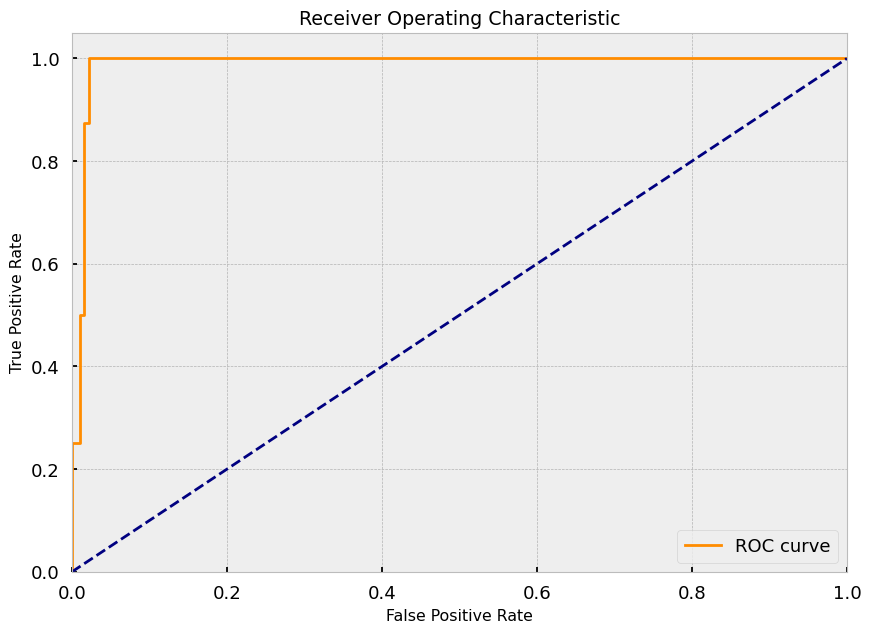

In [212]:
# Initialize the Random Forest Classifier with class_weight='balanced'
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Set up GridSearchCV to optimize for recall or F1-score
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create a scorer for F1-score
f1_scorer = make_scorer(f1_score, pos_label=1)

# Initialize GridSearchCV with the desired scorer
grid_search = GridSearchCV(rf_clf, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
rf_clf = grid_search.best_estimator_

# Make predictions on the test data
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC curve and AUC (optional, if you want to evaluate further)
fpr, tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: Plot the ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [213]:
rf_clf.predict_proba(X_test)

array([[0.96169975, 0.03830025],
       [1.        , 0.        ],
       [0.9622568 , 0.0377432 ],
       [1.        , 0.        ],
       [0.96374583, 0.03625417],
       [0.98      , 0.02      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.20552554, 0.79447446],
       [0.98136536, 0.01863464],
       [1.        , 0.        ],
       [0.17166353, 0.82833647],
       [0.98177998, 0.01822002],
       [1.        , 0.        ],
       [0.98093144, 0.01906856],
       [1.        , 0.        ],
       [0.96374583, 0.03625417],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.9621004 , 0.0378996 ],
       [1.        , 0.        ],
       [0.24463867, 0.75536133],
       [0.9622568 , 0.0377432 ],
       [0.98177998, 0.01822002],
       [0.77369761, 0.22630239],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.16271593, 0.83728407],
       [1.

In [214]:
# # Train the model on the training data
# rf_clf.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = rf_clf.predict(X_test)

# # Evaluate the model
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Compute ROC curve and AUC (optional, if you want to evaluate further)
# fpr, tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])

# # Print the accuracy score
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# # Optional: Plot the ROC curve
# import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

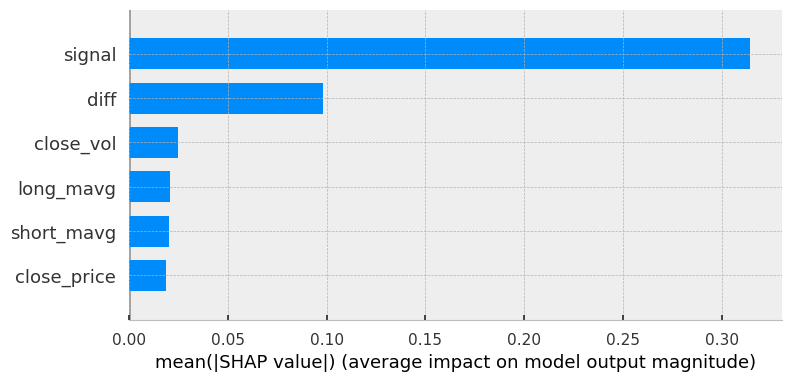

In [215]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_clf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summarize the feature importance
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

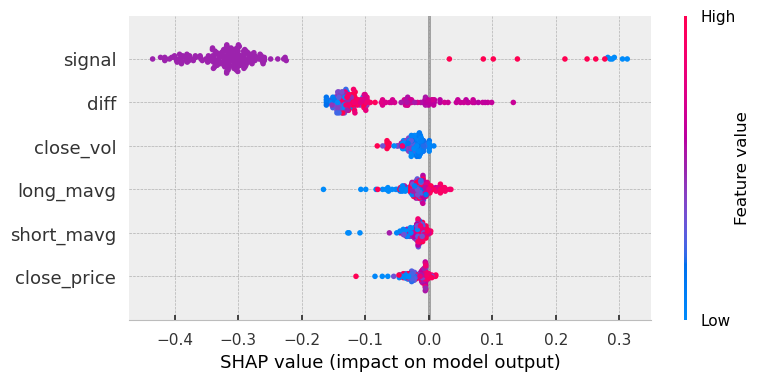

In [216]:
# Create a summary plot
shap.summary_plot(shap_values[1], X_test)


In [217]:
# Visualize the first prediction's SHAP values
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

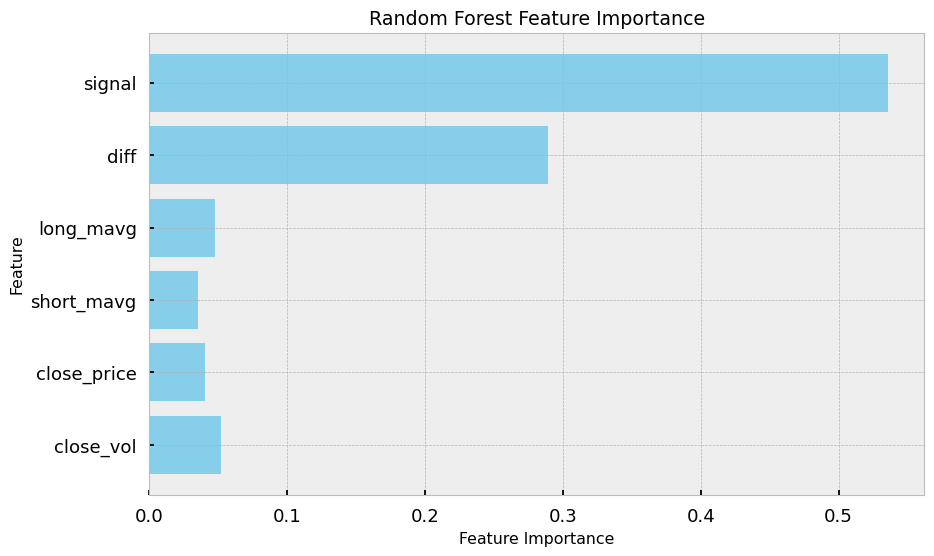

In [218]:
importances = rf_clf.feature_importances_

# Create a plot to visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()
